In [83]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVR
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import plotly.express as px
from xgboost import XGBRegressor

set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/646339800.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [84]:
# Import data
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

# concatenate the two datasets
allsvenskan = pd.concat([allsvenskan, damallsvenskan])

In [85]:
# Assuming 'damallsvenskan' is your dataframe
# Create a column to identify if the next action is a goal
allsvenskan['is_next_goal'] = (allsvenskan['action'].shift(-1) == 'Goal').astype(int)

# Identify shots and whether they resulted in a goal
allsvenskan['is_shot'] = (allsvenskan['action'] == 'Shot').astype(int)
shots = allsvenskan[allsvenskan['is_shot'] == 1]

# Scale coordinates
scale_x = lambda x: x * 120 / 100
scale_y = lambda y: y * 80 / 100

# Apply scaling directly to the dataframe
shots['x'] = shots['xpos'].apply(scale_x)
shots['y'] = shots['ypos'].apply(scale_y)

# Convert 'is_next_goal' to boolean
shots['goal'] = shots['is_next_goal'].astype(bool)

# Select the required columns to form the new dataframe
data = shots[['x', 'y', 'goal']]

# Assuming 'header' is the column you want to add from 'allsvenskan'
data['header'] = shots['header']

data['penalty'] = shots['penalty']

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/1883369360.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = shots['xpos'].apply(scale_x)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/1883369360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['y'] = shots['ypos'].apply(scale_y)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/1883369360.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [86]:
# Define functions for calculating distance and angle
def calculate_angle(x, y):
    width = 7.32
    new_x = 120 - x
    new_y = abs(y - 40)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    theta = np.arctan(tan_theta) * (180 / np.pi)  # Convert radians to degrees
    return theta

def calculate_dist(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

# Apply the functions to the dataframe
data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)

data.head(10)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/1493875045.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_82029/1493875045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)


,x,y,goal,header,penalty,angle,distance
74,109.2,55.2,False,False,False,13.305603,18.646179
106,111.6,24.8,False,False,False,12.043411,17.366635
114,98.4,30.4,False,False,False,16.169050,23.637259
163,114.0,39.2,True,True,False,62.110234,6.053098
269,92.4,44.0,False,False,False,14.805480,27.888349
337,111.6,24.8,False,False,False,12.043411,17.366635
353,116.4,37.6,True,True,False,78.577219,4.326662
428,112.8,26.4,True,False,False,13.274114,15.388307
453,104.4,41.6,True,False,False,26.155509,15.681837
483,109.2,48.0,False,False,False,25.299982,13.440238


In [87]:
# Data
X = data[['distance', 'angle', 'header', 'penalty']]
y = data['goal'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Support Vector Machine

In [88]:
# Initialize the SVR model with a pipeline
svm_model = make_pipeline(StandardScaler(), SVR())

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_svm = -cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_svm}')

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model using regression metrics
mae_svm = mean_absolute_error(y_test, y_pred)
mse_svm = mean_squared_error(y_test, y_pred)
rmse_svm = np.sqrt(mse_svm)  # Calculating RMSE
r2_svm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_svm}')
print(f'Mean Squared Error (MSE): {mse_svm}')
print(f'Root Mean Squared Error (RMSE): {rmse_svm}')
print(f'R-squared (R²): {r2_svm}')

Cross-Validated Mean Squared Error: 0.08792642563443684
Mean Absolute Error (MAE): 0.1779192767874125
Mean Squared Error (MSE): 0.0868802904225995
Root Mean Squared Error (RMSE): 0.29475462748292774
R-squared (R²): 0.10049682168585994


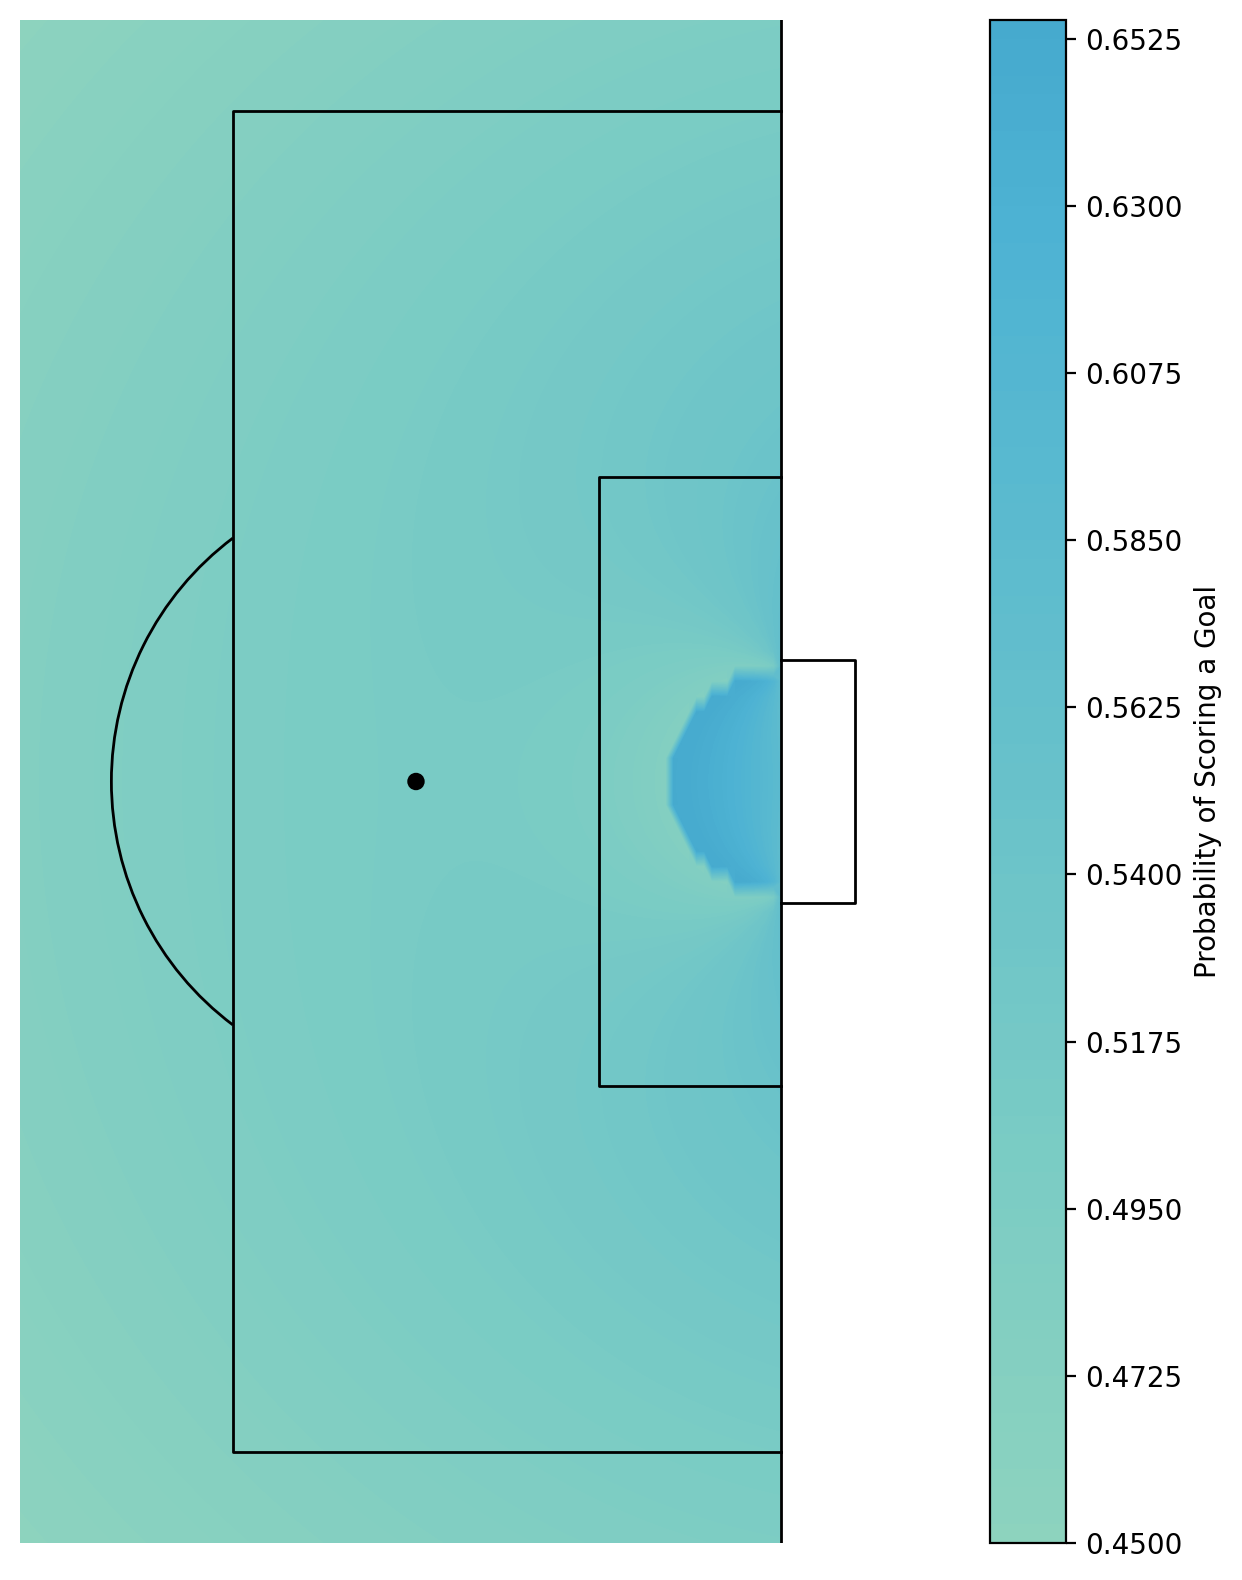

In [89]:
# Adjusted grid for higher resolution
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution
xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Assuming header is binary, let's add header = 0 for non-header attempts
# Update this line to create a full feature set including the header
# For simplicity, this example assumes all attempts are non-header. Adjust if needed.
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])  # Assuming header=0

# Scale the features as before and predict goal probabilities
scaled_full_grid_points = svm_model.named_steps['standardscaler'].transform(full_grid_points)  # Use fitted scaler
goal_predictions = svm_model.predict(scaled_full_grid_points)  # Regression predictions

# Reshape for plotting
goal_pred_matrix = goal_predictions.reshape(xx.shape)

# Plotting with increased resolution
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Set vmin and vmax for color scale
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')

# Zoom in to the penalty area
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')

plt.show()

## Decision Tree 

In [90]:
# Initialize the Decision Tree model
tree_model = DecisionTreeRegressor(max_depth=5)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_mse_dt = -cross_val_score(tree_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_dt}')

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Predictions
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred)
mae_dt = mean_absolute_error(y_test, y_pred)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_dt}')
print(f'Mean Squared Error (MSE): {mse_dt}')
print(f'Root Mean Squared Error (RMSE): {rmse_dt}')
print(f'R-squared (R²): {r2_dt}')

Cross-Validated Mean Squared Error: 0.08167983218794976
Mean Absolute Error (MAE): 0.16090633809593655
Mean Squared Error (MSE): 0.08066638028600176
Root Mean Squared Error (RMSE): 0.2840182745634544
R-squared (R²): 0.16483168855198382


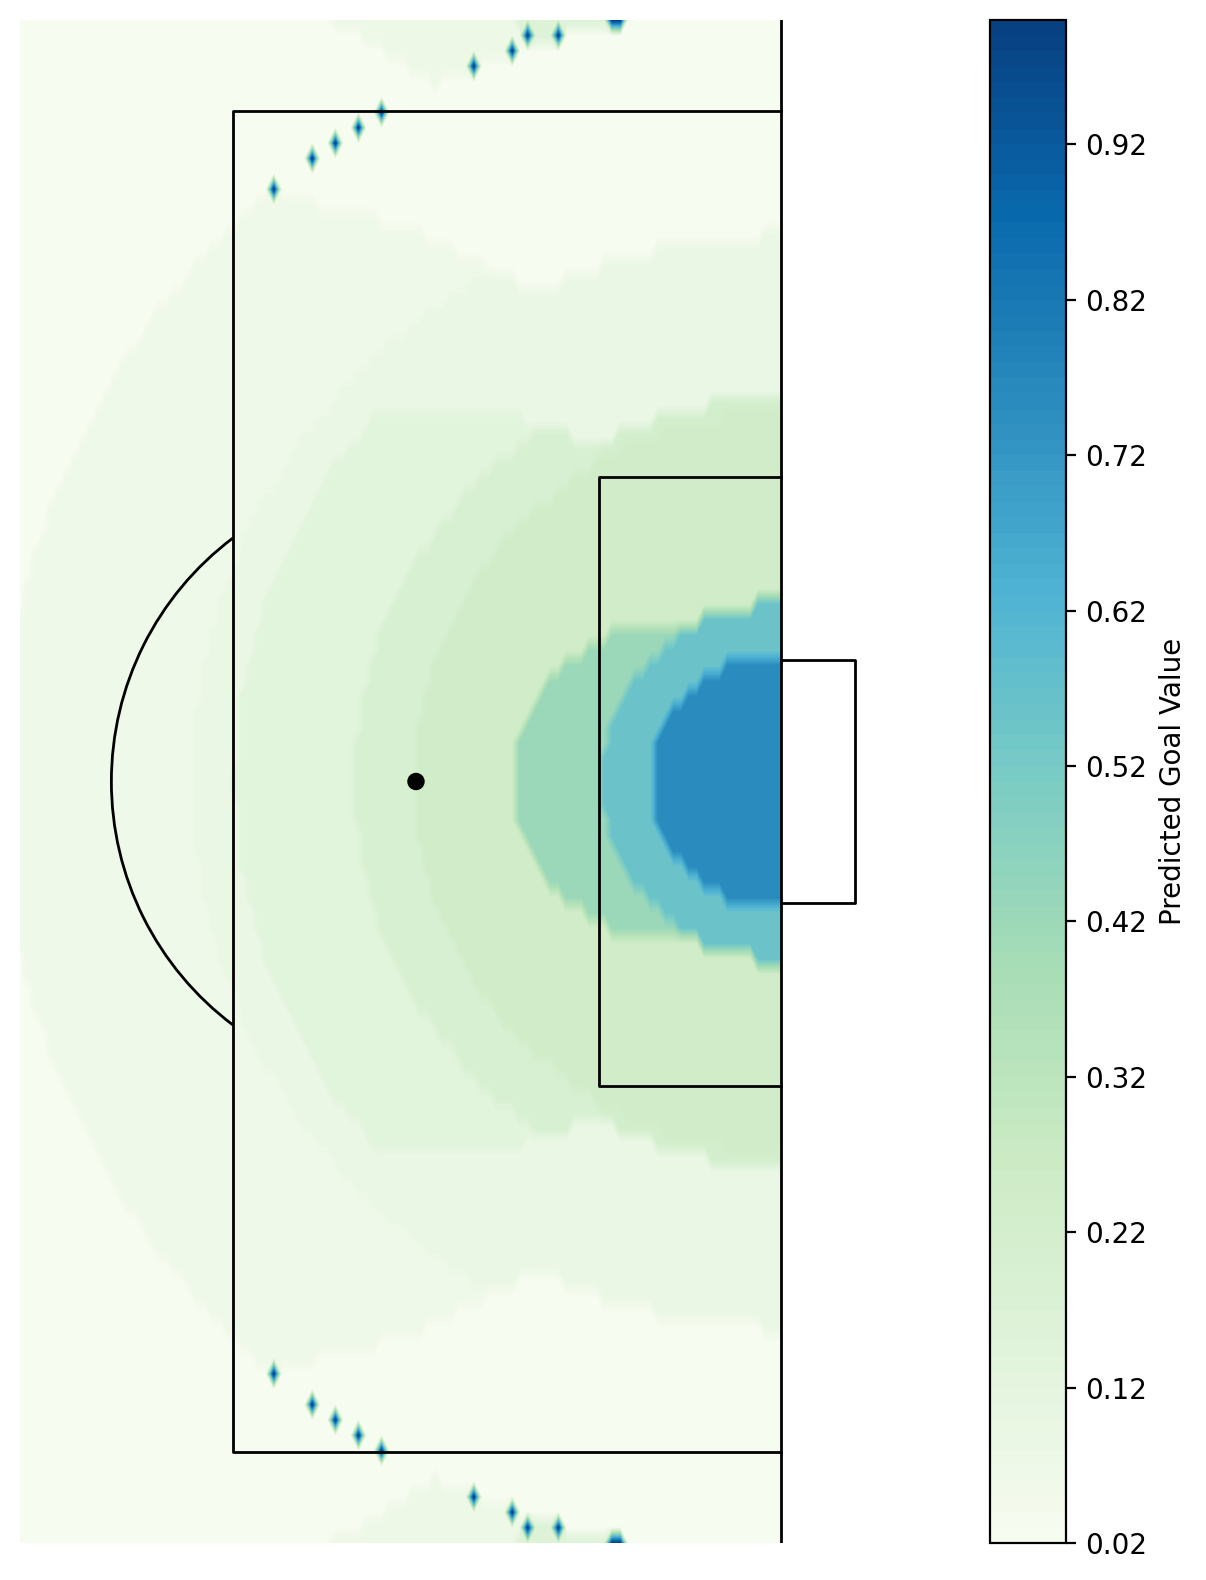

In [91]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

# Calculate predictions instead of probabilities
goal_predictions = tree_model.predict(full_grid_points)
goal_pred_matrix = goal_predictions.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_pred_matrix, cmap='GnBu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Predicted Goal Value')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Random Forest

In [92]:
forest_model = RandomForestRegressor(n_estimators=100, max_depth=5)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for MSE estimation
cv_mse_rm = -cross_val_score(forest_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_rm}')

# Fit the model on the training data
forest_model.fit(X_train, y_train)

# Predictions
y_pred = forest_model.predict(X_test)

# Evaluate the model using regression metrics
mae_rm = mean_absolute_error(y_test, y_pred)
mse_rm = mean_squared_error(y_test, y_pred)
rmse_rm = np.sqrt(mse_rm)  # Calculating RMSE
r2_rm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_rm}')
print(f'Mean Squared Error (MSE): {mse_rm}')
print(f'Root Mean Squared Error (RMSE): {rmse_rm}')
print(f'R-squared (R²): {r2_rm}')

Cross-Validated Mean Squared Error: 0.08107479014718857
Mean Absolute Error (MAE): 0.16107748495234578
Mean Squared Error (MSE): 0.08035075766463942
Root Mean Squared Error (RMSE): 0.2834620921122248
R-squared (R²): 0.16809944410024802


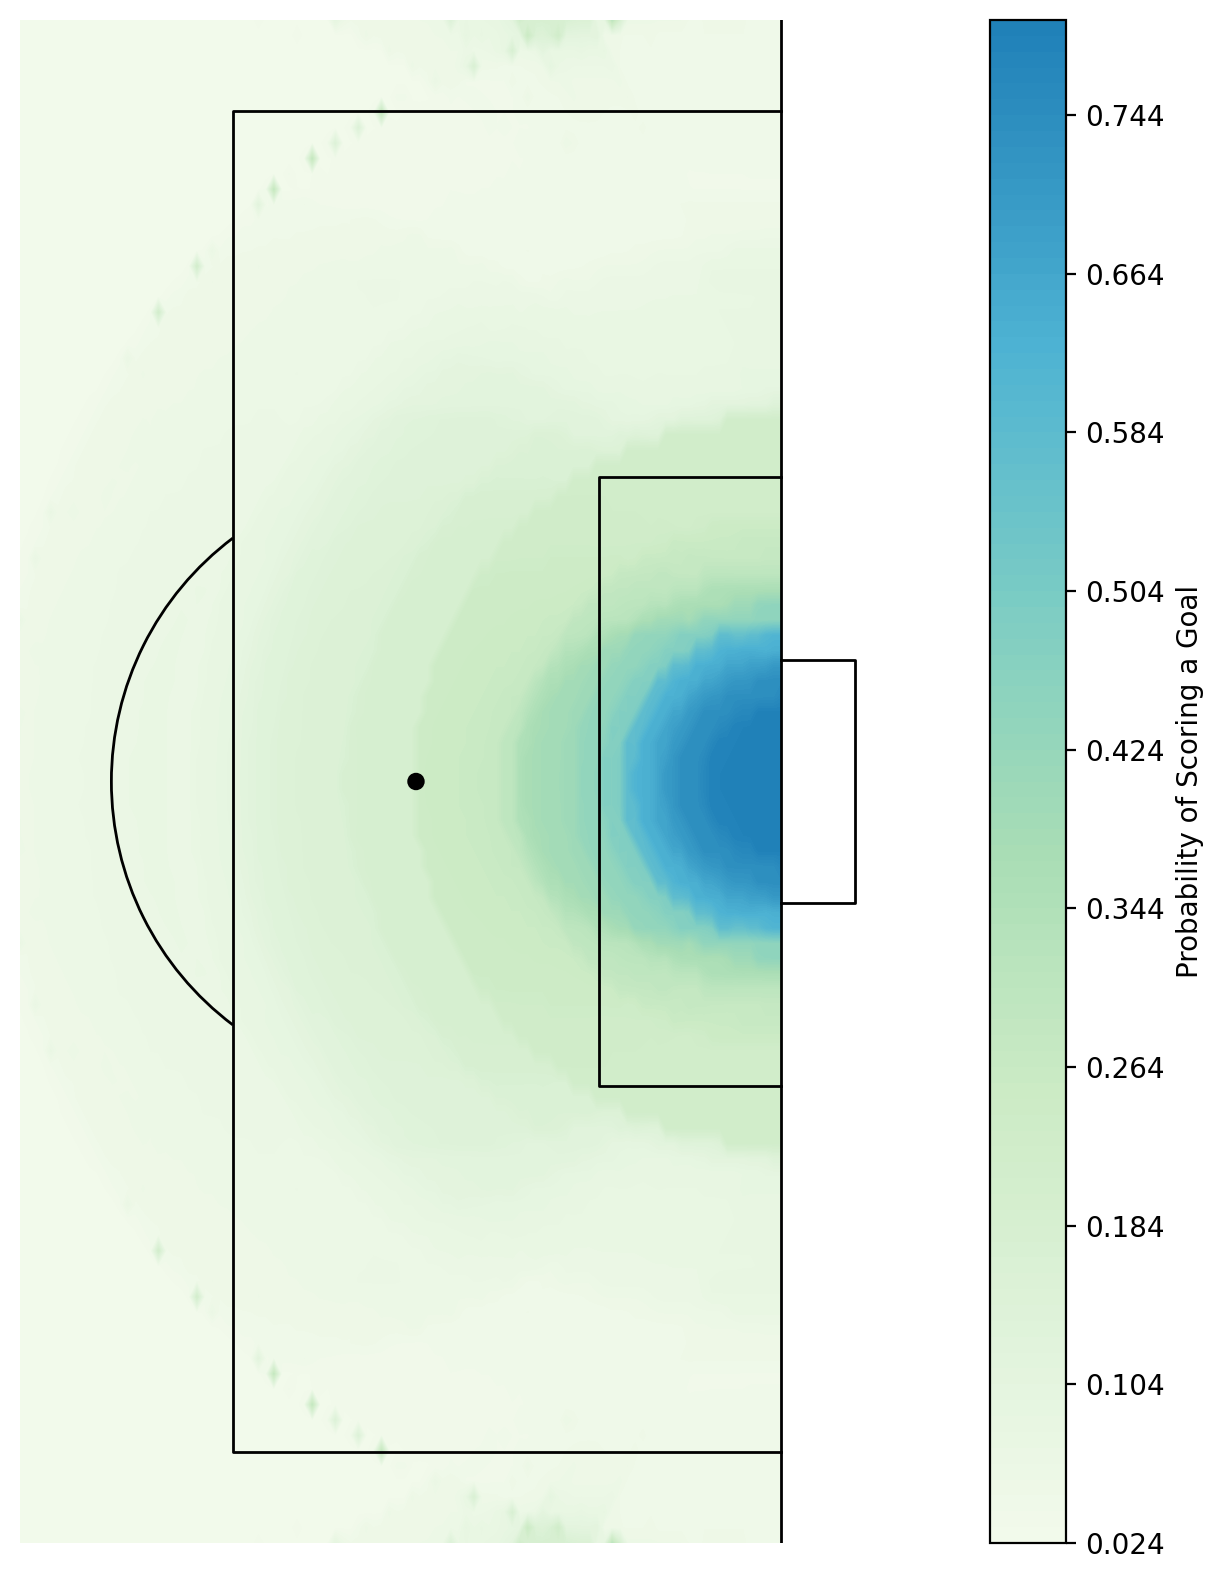

In [93]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = forest_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Neural Network

In [94]:
# Initialize the Neural Network model for regression
nn_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

# Use K-Fold for cross-validation in a regression task
cv = KFold(n_splits=5)

# Note: Cross-validating neural networks can be computationally expensive, so adjust n_splits accordingly

# Cross-validation across the entire dataset for MSE estimation
cv_mse_nn = -cross_val_score(nn_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_nn}')

# Fit the model on the training data
nn_model.fit(X_train, y_train)

# Predictions
y_pred = nn_model.predict(X_test)

# Evaluate the model using regression metrics
mae_nn = mean_absolute_error(y_test, y_pred)
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)  # Calculating RMSE
r2_nn = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_nn}')
print(f'Mean Squared Error (MSE): {mse_nn}')
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')
print(f'R-squared (R²): {r2_nn}')

Cross-Validated Mean Squared Error: 0.08404177222213431
Mean Absolute Error (MAE): 0.17011608376442516
Mean Squared Error (MSE): 0.08102324739389109
Root Mean Squared Error (RMSE): 0.28464582799312393
R-squared (R²): 0.16113691386579398


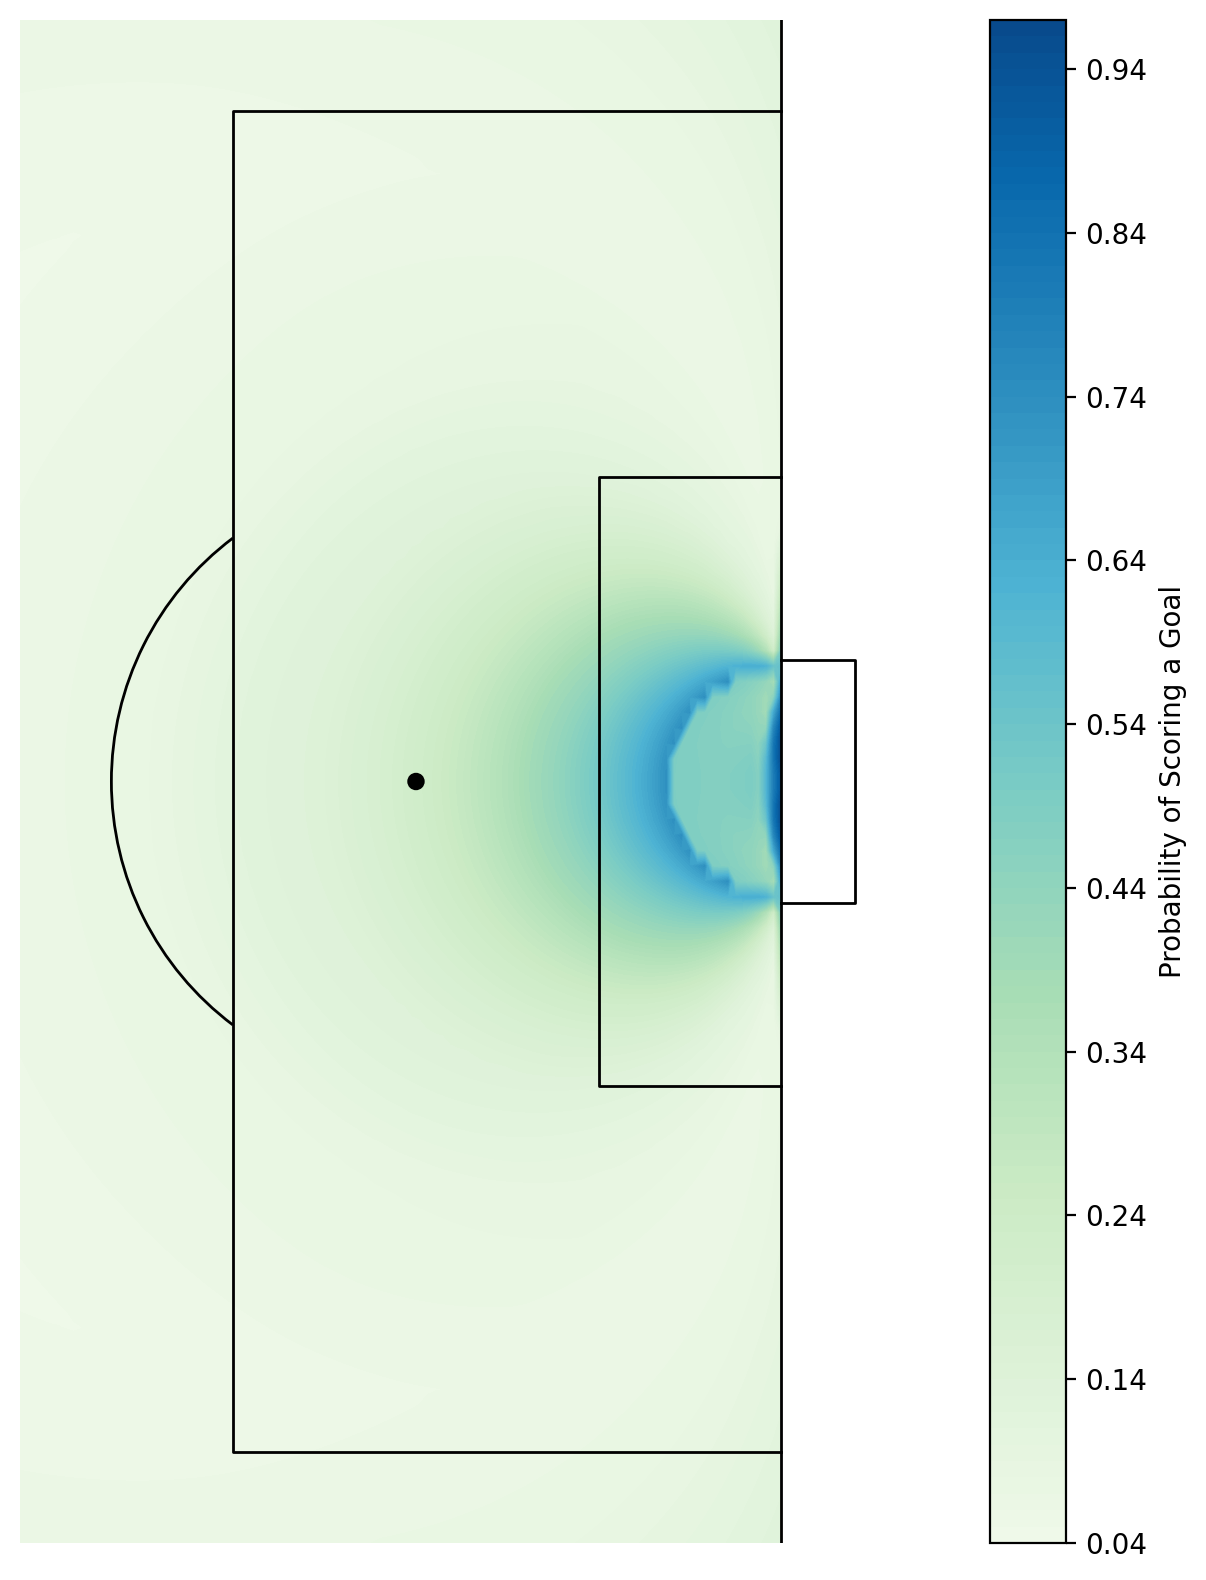

In [95]:
# Plot 
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = nn_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Logistic Regression

In [96]:
# Initialize the Logistic Regression model
log_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed for convergence

# Use K-Fold for cross-validation, more suitable for regression-like evaluation
cv = KFold(n_splits=5)

# Note: While logistic regression is typically used for classification, here we are interested in the predicted probabilities as continuous outcomes.
# Cross-validation to estimate model performance; we use 'neg_mean_squared_error' to stay consistent with regression evaluation
cv_neg_mse_log = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
cv_mse_log = -cv_neg_mse_log  # Convert to positive value
print(f'Cross-Validated Mean Squared Error: {cv_mse_log}')

# Fit the model on the training data
log_model.fit(X_train, y_train)

# Predictions - get probabilities for the positive class
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluate the model using regression metrics for the predicted probabilities
mae_log = mean_absolute_error(y_test, y_pred_proba)
mse_log = mean_squared_error(y_test, y_pred_proba)
rmse_log = np.sqrt(mse_log)  # Calculating RMSE
r2_log = r2_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_log}')
print(f'Mean Squared Error (MSE): {mse_log}')
print(f'Root Mean Squared Error (RMSE): {rmse_log}')
print(f'R-squared (R²): {r2_log}')

Cross-Validated Mean Squared Error: 0.10136054421768707
Mean Absolute Error (MAE): 0.165054831972296
Mean Squared Error (MSE): 0.08167565762810527
Root Mean Squared Error (RMSE): 0.28578953379734756
R-squared (R²): 0.15438227393093862


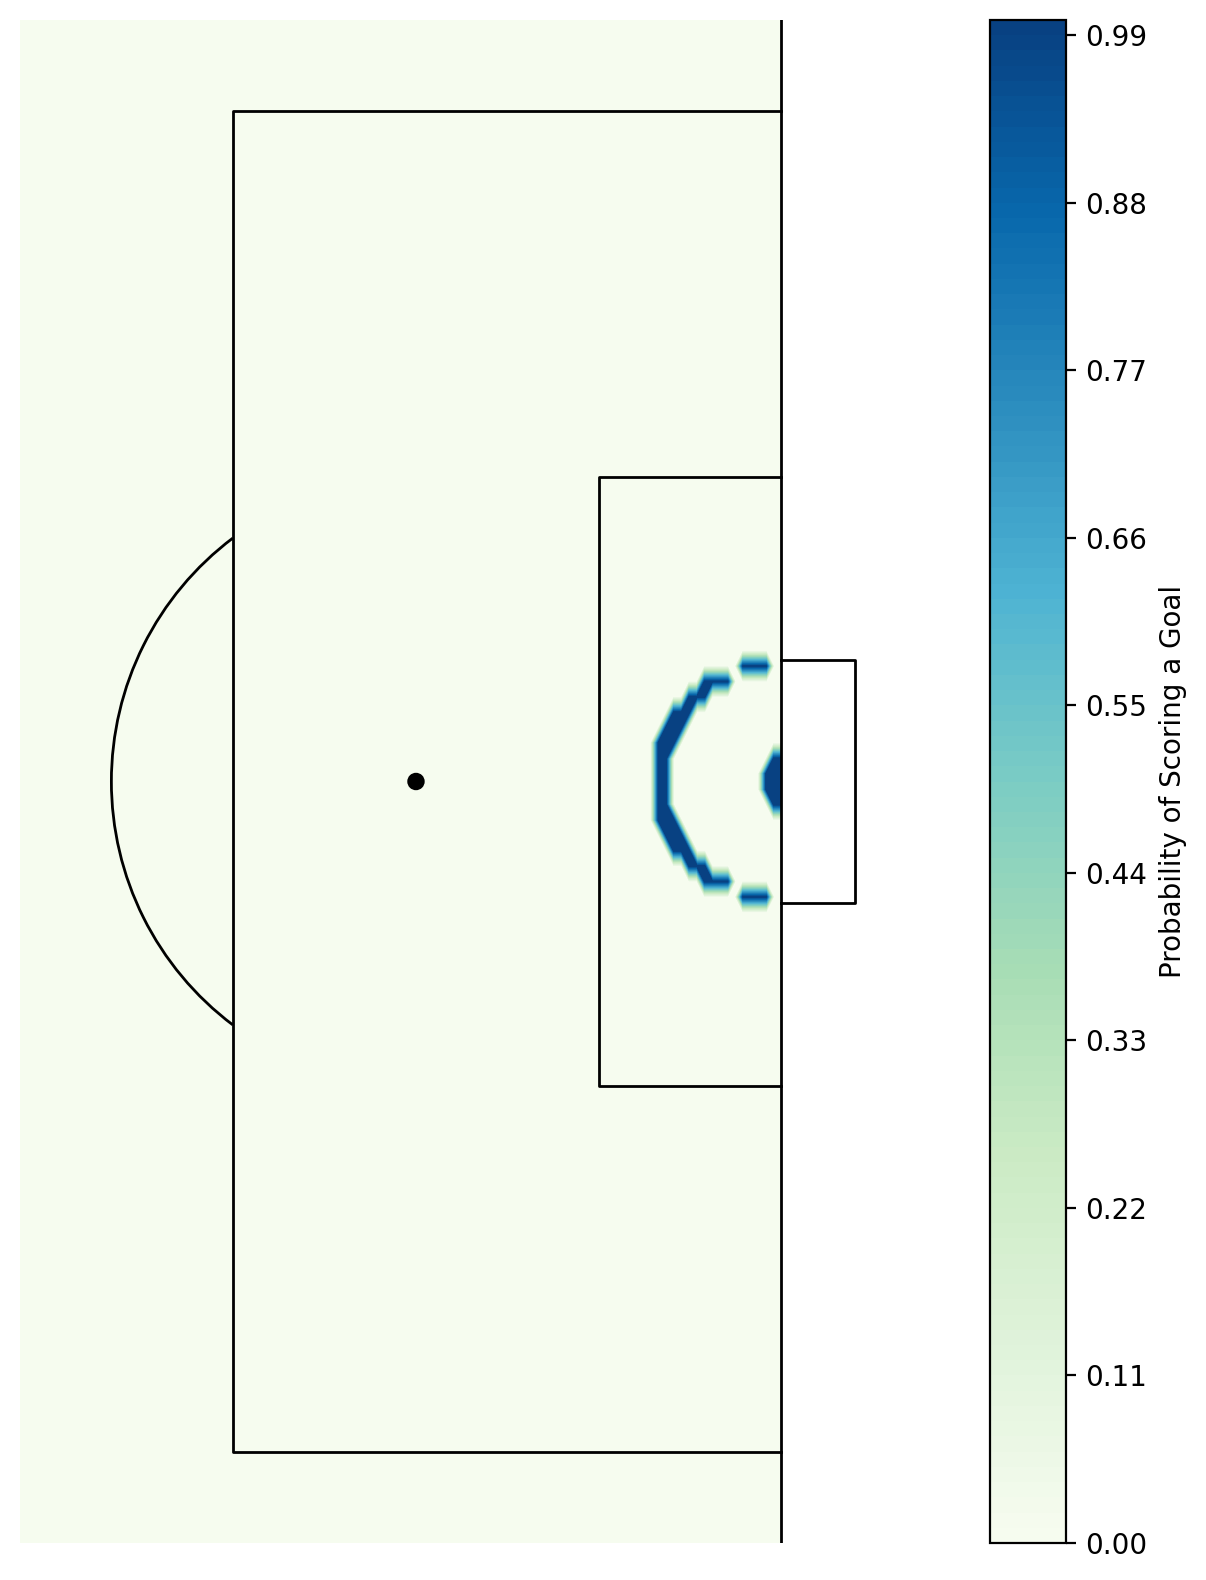

In [97]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = log_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Linear Regression

In [98]:
linear_model = make_pipeline(PolynomialFeatures(2), BayesianRidge())
linear_model.fit(X_train, y_train)

# Use KFold for regression tasks
cv = StratifiedKFold(n_splits=5)

# Use an appropriate scoring metric for regression, e.g., 'neg_mean_squared_error'
cv_score_lin = cross_val_score(linear_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
# Convert back to positive mean squared error for interpretability
cv_score_lin = -cv_score_lin
print(f'Cross-Validated Mean Squared Error: {cv_score_lin}')

# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)  # Calculating RMSE
r2_linear = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_linear}')
print(f'Mean Squared Error (MSE): {mse_linear}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear}')
print(f'R-squared (R²): {r2_linear}')

Cross-Validated Mean Squared Error: 0.08143398663766875
Mean Absolute Error (MAE): 0.1622425024872164
Mean Squared Error (MSE): 0.08105162246027549
Root Mean Squared Error (RMSE): 0.28469566638829524
R-squared (R²): 0.16084313650531923


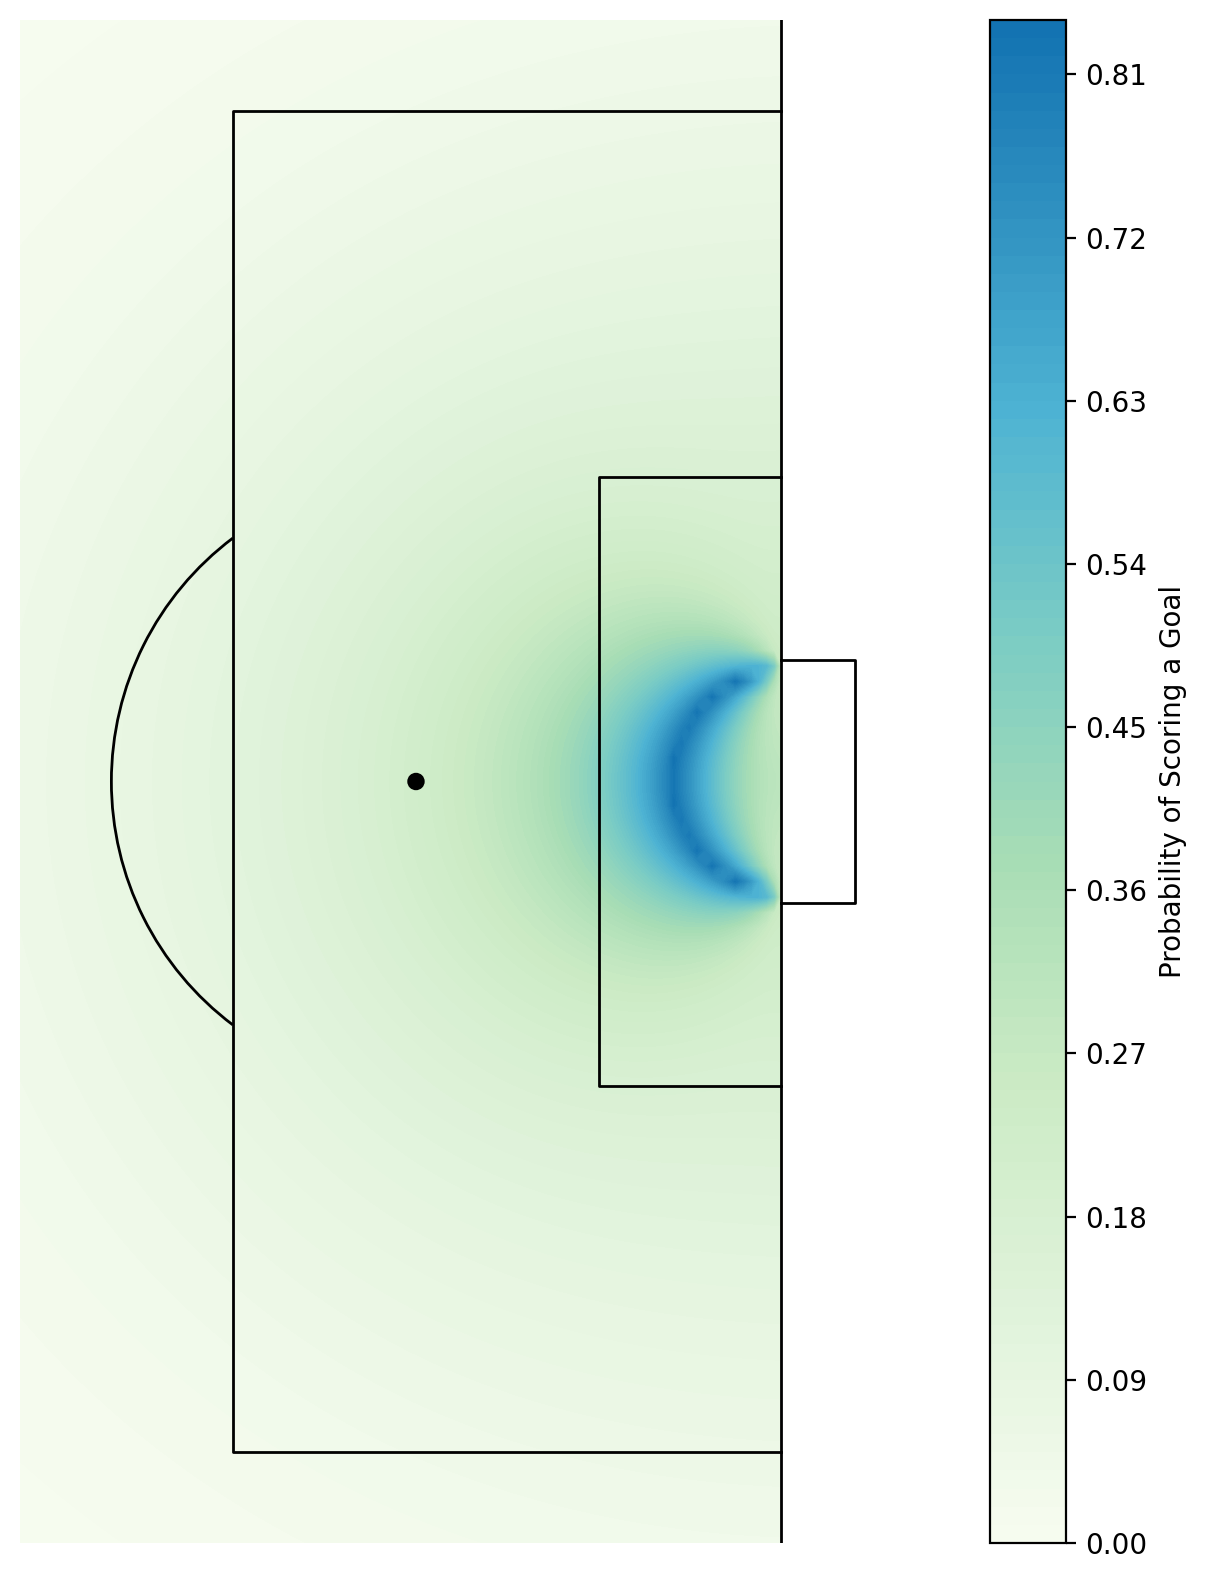

In [99]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = linear_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## XGBoost

In [100]:
# Initialize the XGBoost model for regression
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='logloss')

# Use K-Fold for cross-validation, appropriate for regression tasks
cv = KFold(n_splits=5)

# Cross-validation across the entire dataset for a general performance estimation using MSE
cv_mse_xgb = -cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
print(f'Cross-Validated Mean Squared Error: {cv_mse_xgb}')

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using regression metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)  # Calculating RMSE
r2_xgb = r2_score(y_test, y_pred)

# Print the evaluation metrics for regression
print(f'Mean Absolute Error (MAE): {mae_xgb}')
print(f'Mean Squared Error (MSE): {mse_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb}')
print(f'R-squared (R²): {r2_xgb}')

Cross-Validated Mean Squared Error: 0.08302151470340445
Mean Absolute Error (MAE): 0.1607663170806465
Mean Squared Error (MSE): 0.0817924487987898
Root Mean Squared Error (RMSE): 0.28599379153888954
R-squared (R²): 0.15317309255368072


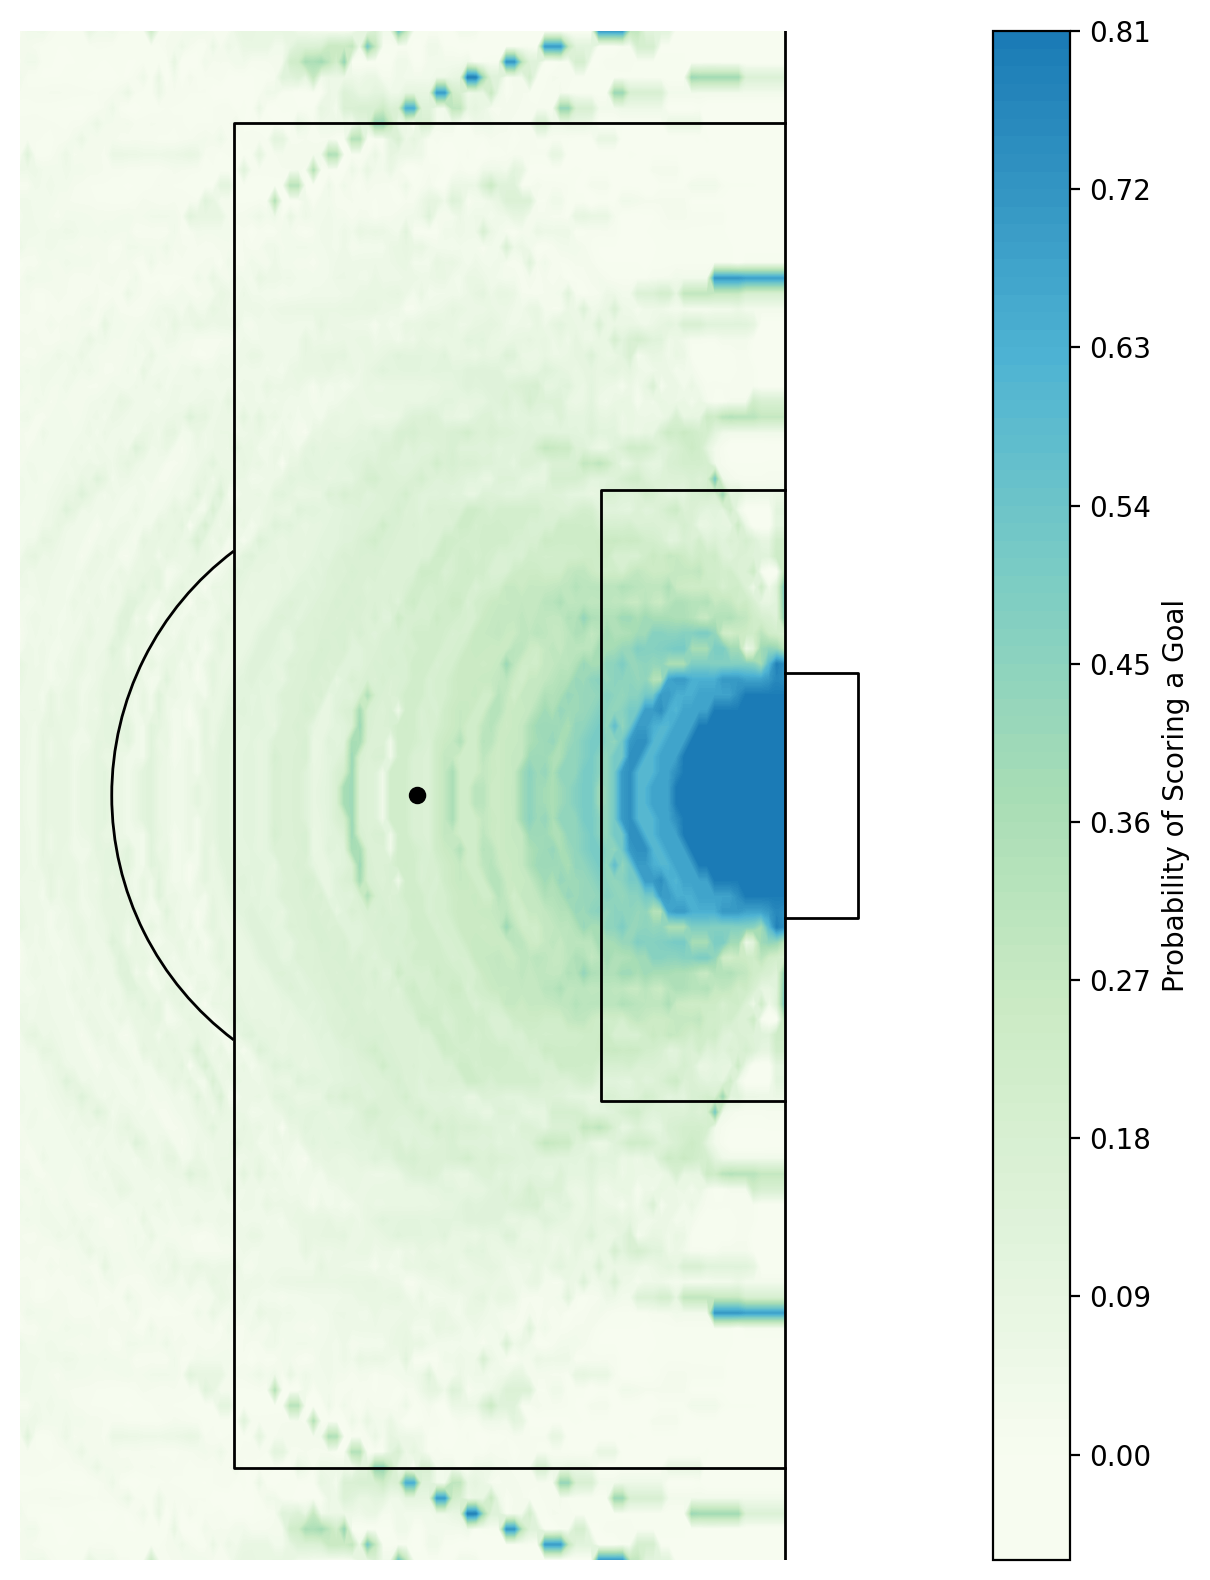

In [101]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = xgb_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='GnBu', levels=100, zorder=1, vmin=0, vmax=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)
# Adjust layout and save the figure before plt.show()
plt.tight_layout()
plt.savefig('img_models/svm_model_heatmap.png', bbox_inches='tight')
plt.show()

## Comparing Model Performance

In [102]:
# Data for regression models
types_of_models = ['Support Vector Regression', 'Decision Tree', 'Random Forest', 'Neural Network', 'Logistic Regression', 'Bayesian Ridge', 'XGBoost']
cv_mse_values = [cv_mse_svm, cv_mse_dt, cv_mse_rm, cv_mse_nn, cv_mse_log, cv_score_lin, cv_mse_xgb]
mae_values = [mae_svm, mae_dt, mae_rm, mae_nn, mae_log, mae_linear, mae_xgb]
mse_values = [mse_svm, mse_dt, mse_rm, mse_nn, mse_log, mse_linear, mse_xgb]
rmse_values = [rmse_svm, rmse_dt, rmse_rm, rmse_nn, rmse_log, rmse_linear, rmse_xgb]
r2_values = [r2_svm, r2_dt, r2_rm, r2_nn, r2_log, r2_linear, r2_xgb]

df = pd.DataFrame({'Model': types_of_models, 'Cross-Validated MSE': cv_mse_values, 'MAE': mae_values, 'MSE': mse_values, 'RMSE': rmse_values, 'R²': r2_values})
df = df.sort_values(by='Cross-Validated MSE', ascending=False)
df

,Model,Cross-Validated MSE,MAE,MSE,RMSE,R²
4,Logistic Regression,0.101361,0.165055,0.081676,0.285790,0.154382
0,Support Vector Regression,0.087926,0.177919,0.086880,0.294755,0.100497
3,Neural Network,0.084042,0.170116,0.081023,0.284646,0.161137
6,XGBoost,0.083022,0.160766,0.081792,0.285994,0.153173
1,Decision Tree,0.081680,0.160906,0.080666,0.284018,0.164832
5,Bayesian Ridge,0.081434,0.162243,0.081052,0.284696,0.160843
2,Random Forest,0.081075,0.161077,0.080351,0.283462,0.168099


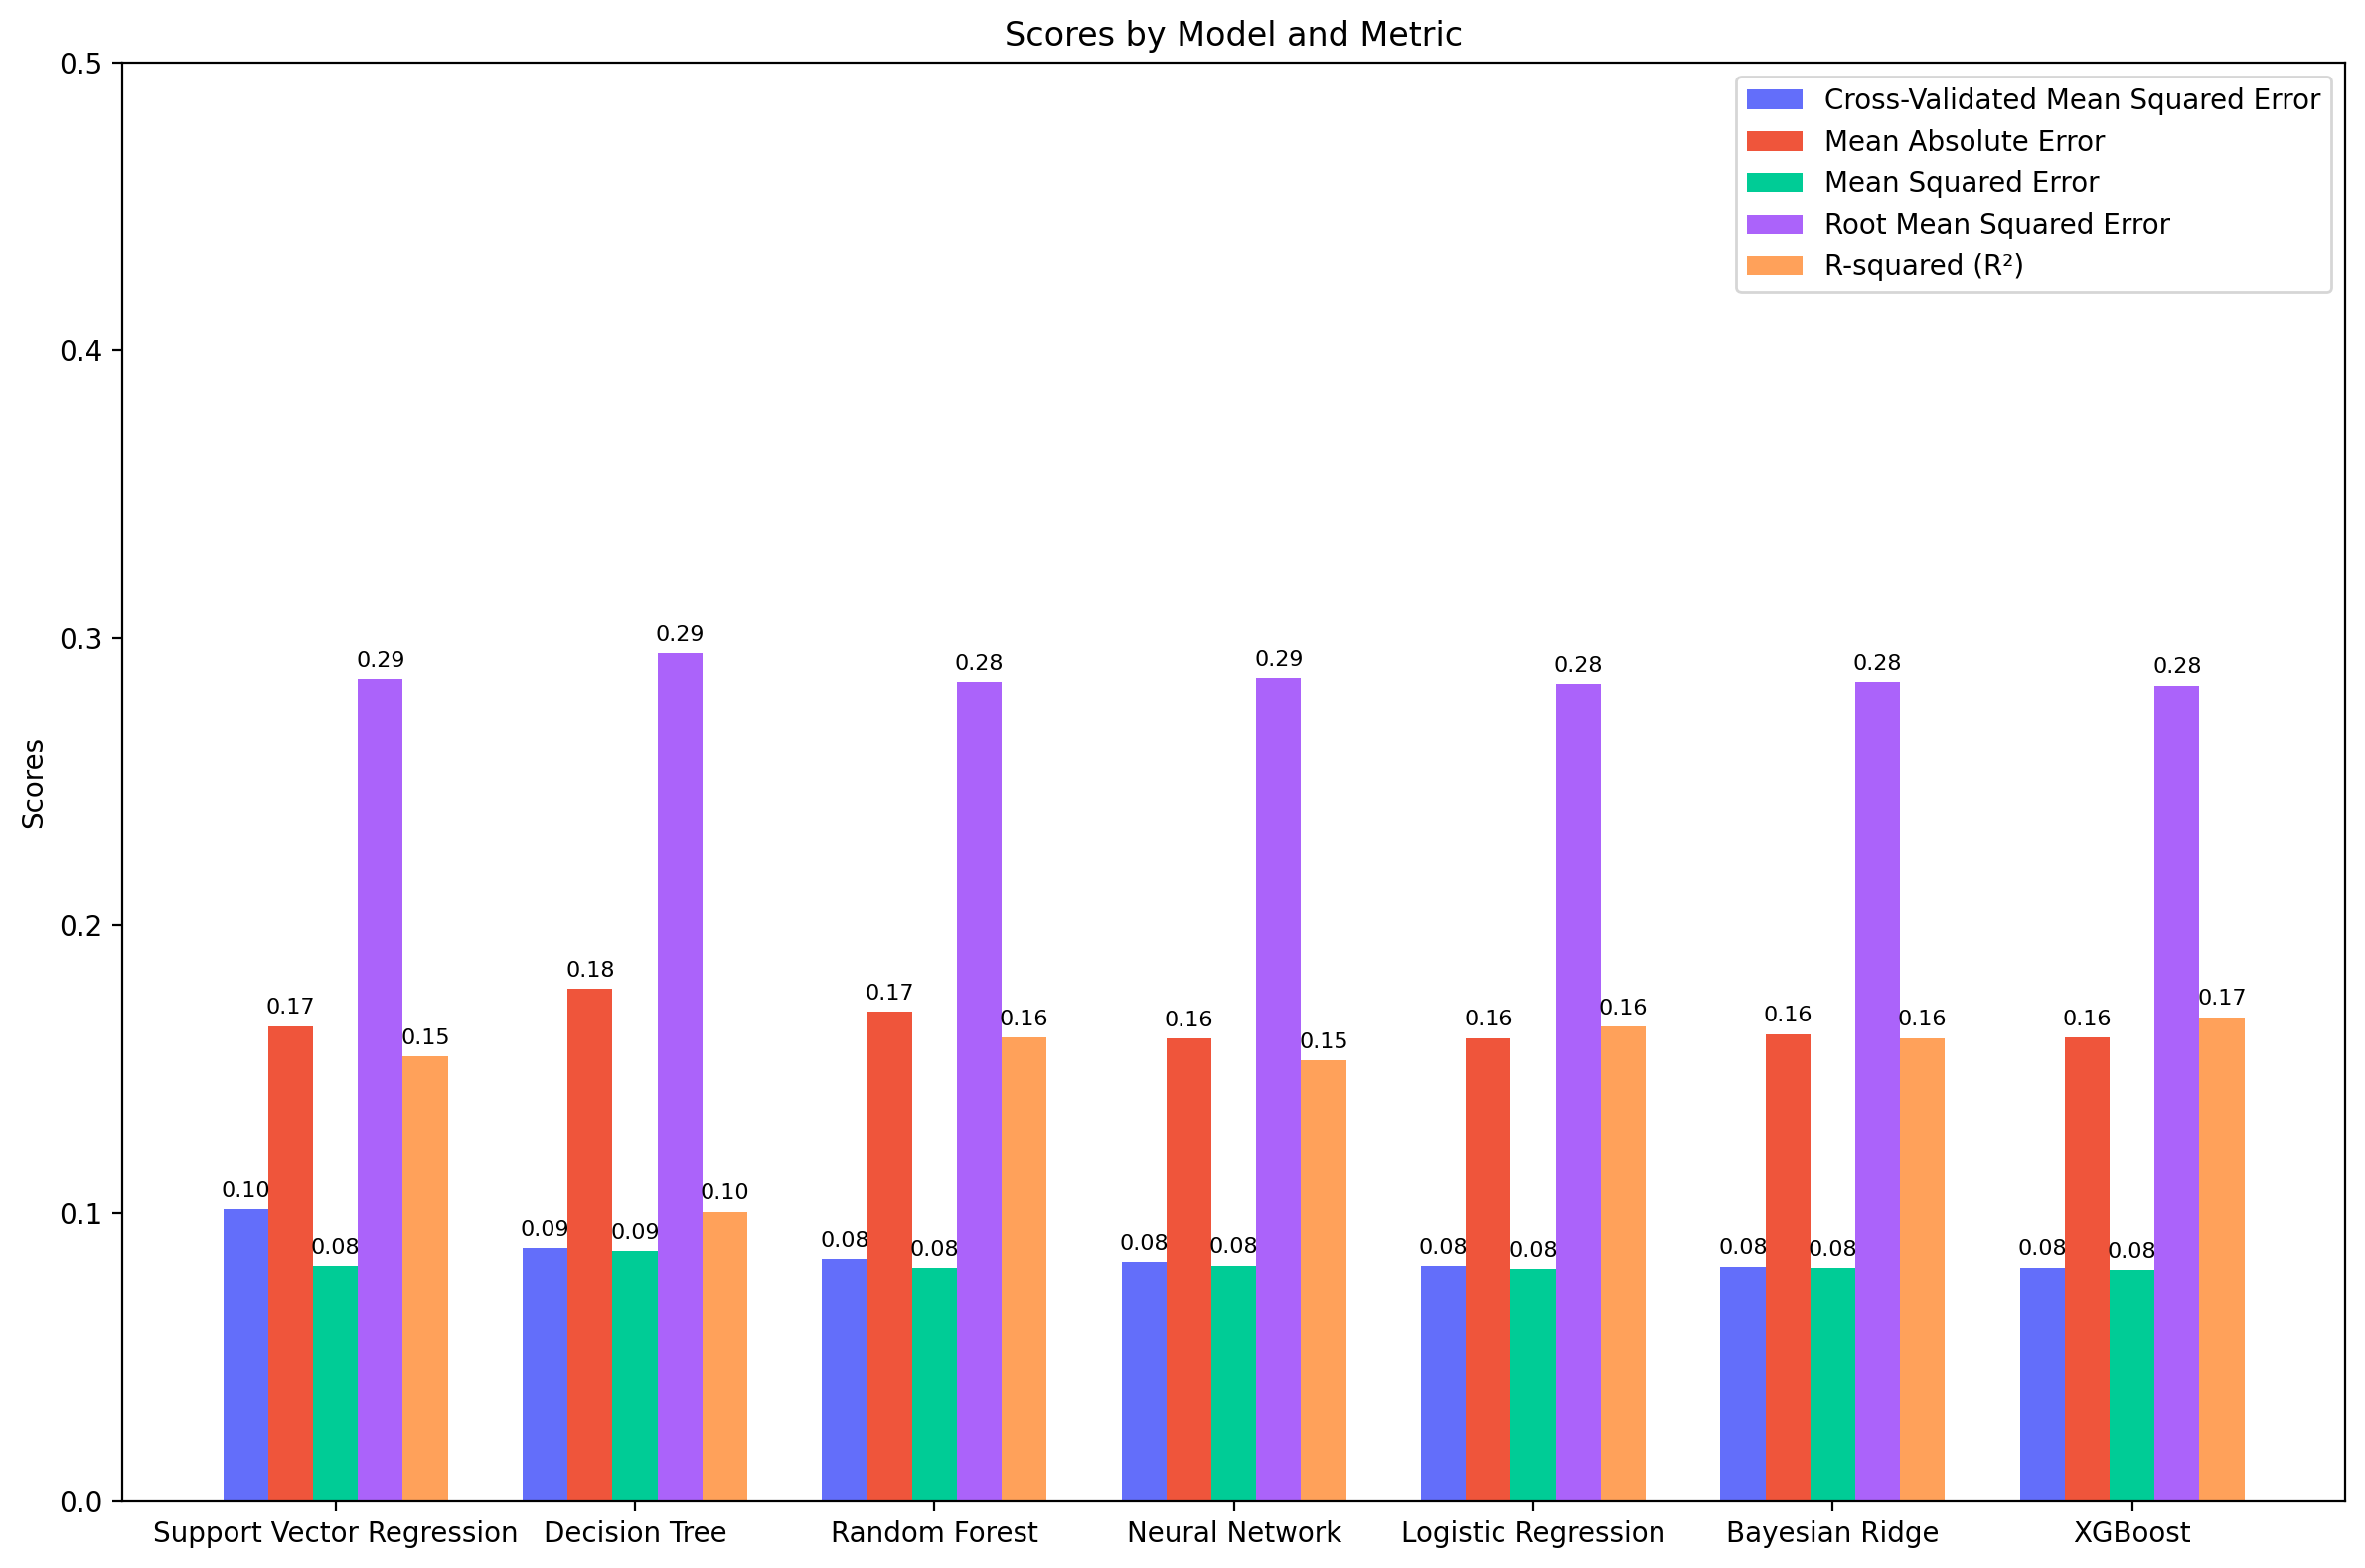

In [103]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(types_of_models))  # the label locations
width = 0.15  # the width of the bars

# Use Plotly's qualitative color map
cmap = px.colors.qualitative.Plotly

# Plot each metric with direct color assignment from cmap
rects1 = ax.bar(x - 2 * width, df['Cross-Validated MSE'], width, label='Cross-Validated Mean Squared Error', color=cmap[0])
rects2 = ax.bar(x - width, df['MAE'], width, label='Mean Absolute Error', color=cmap[1])
rects3 = ax.bar(x, df['MSE'], width, label='Mean Squared Error', color=cmap[2])
rects4 = ax.bar(x + width, df['RMSE'], width, label='Root Mean Squared Error', color=cmap[3])
rects5 = ax.bar(x + 2 * width, df['R²'], width, label='R-squared (R²)', color=cmap[4])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(x)
ax.set_xticklabels(types_of_models)
ax.legend()
ax.set_ylim(0, 0.5)

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)
add_labels(rects5)

fig.tight_layout()
plt.savefig('img_models/model_comparison.png')
plt.show()